<a href="https://colab.research.google.com/github/sauravsingla/General/blob/master/Sensor_Signal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.feature_selection import SelectPercentile, f_classif, SelectFromModel, RFE

from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, confusion_matrix
from sklearn import metrics

from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline

plt.rc("font", size=14)
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [ ]:
df_all = pd.read_csv("/content/task_data.csv")

In [ ]:
df_all.head()

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


count    400.000000
mean       0.000000
std        1.001252
min       -1.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: class_label, dtype: float64


-1.0    200
 1.0    200
Name: class_label, dtype: int64

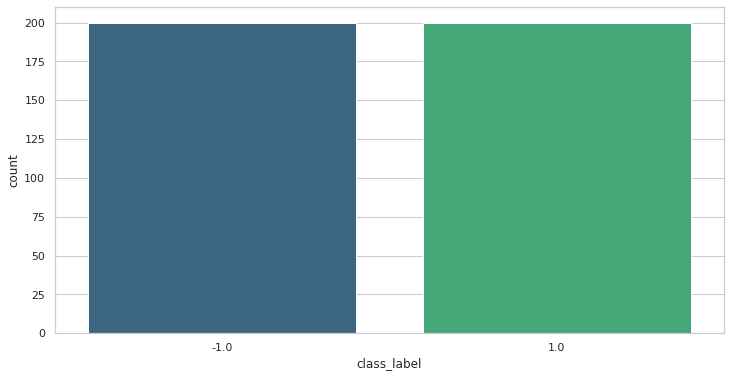

In [ ]:
# Class_label distribution
plt.figure(figsize=(12,6))
sns.countplot(df_all['class_label'],palette='viridis')
print(df_all['class_label'].describe())
df_all['class_label'].value_counts()

In [ ]:
# There are no missing values
def missing_zero_values_table(df_all):
        zero_val = (df_all == 0.00).astype(int).sum(axis=0)
        mis_val = df_all.isnull().sum()
        mis_val_percent = 100 * df_all.isnull().sum() / len(df_all)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df_all)
        mz_table['Data Type'] = df_all.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df_all.shape[1]) + " columns and " + str(df_all.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

missing_zero_values_table(df_all)

Your selected dataframe has 12 columns and 400 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [ ]:
# Data type and their frequency
print("Data types and their frequency\n{}".format(df_all.dtypes.value_counts()))

Data types and their frequency
float64    11
object      1
dtype: int64


In [ ]:
# Checking the structure and data type
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
sample index    400 non-null object
class_label     400 non-null float64
sensor0         400 non-null float64
sensor1         400 non-null float64
sensor2         400 non-null float64
sensor3         400 non-null float64
sensor4         400 non-null float64
sensor5         400 non-null float64
sensor6         400 non-null float64
sensor7         400 non-null float64
sensor8         400 non-null float64
sensor9         400 non-null float64
dtypes: float64(11), object(1)
memory usage: 37.6+ KB


In [ ]:
# Name of the columns
df_all.columns

Index(['sample index', 'class_label', 'sensor0', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9'],
      dtype='object')

In [ ]:
# Descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution
df_all[['sensor0', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9']].describe()

,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


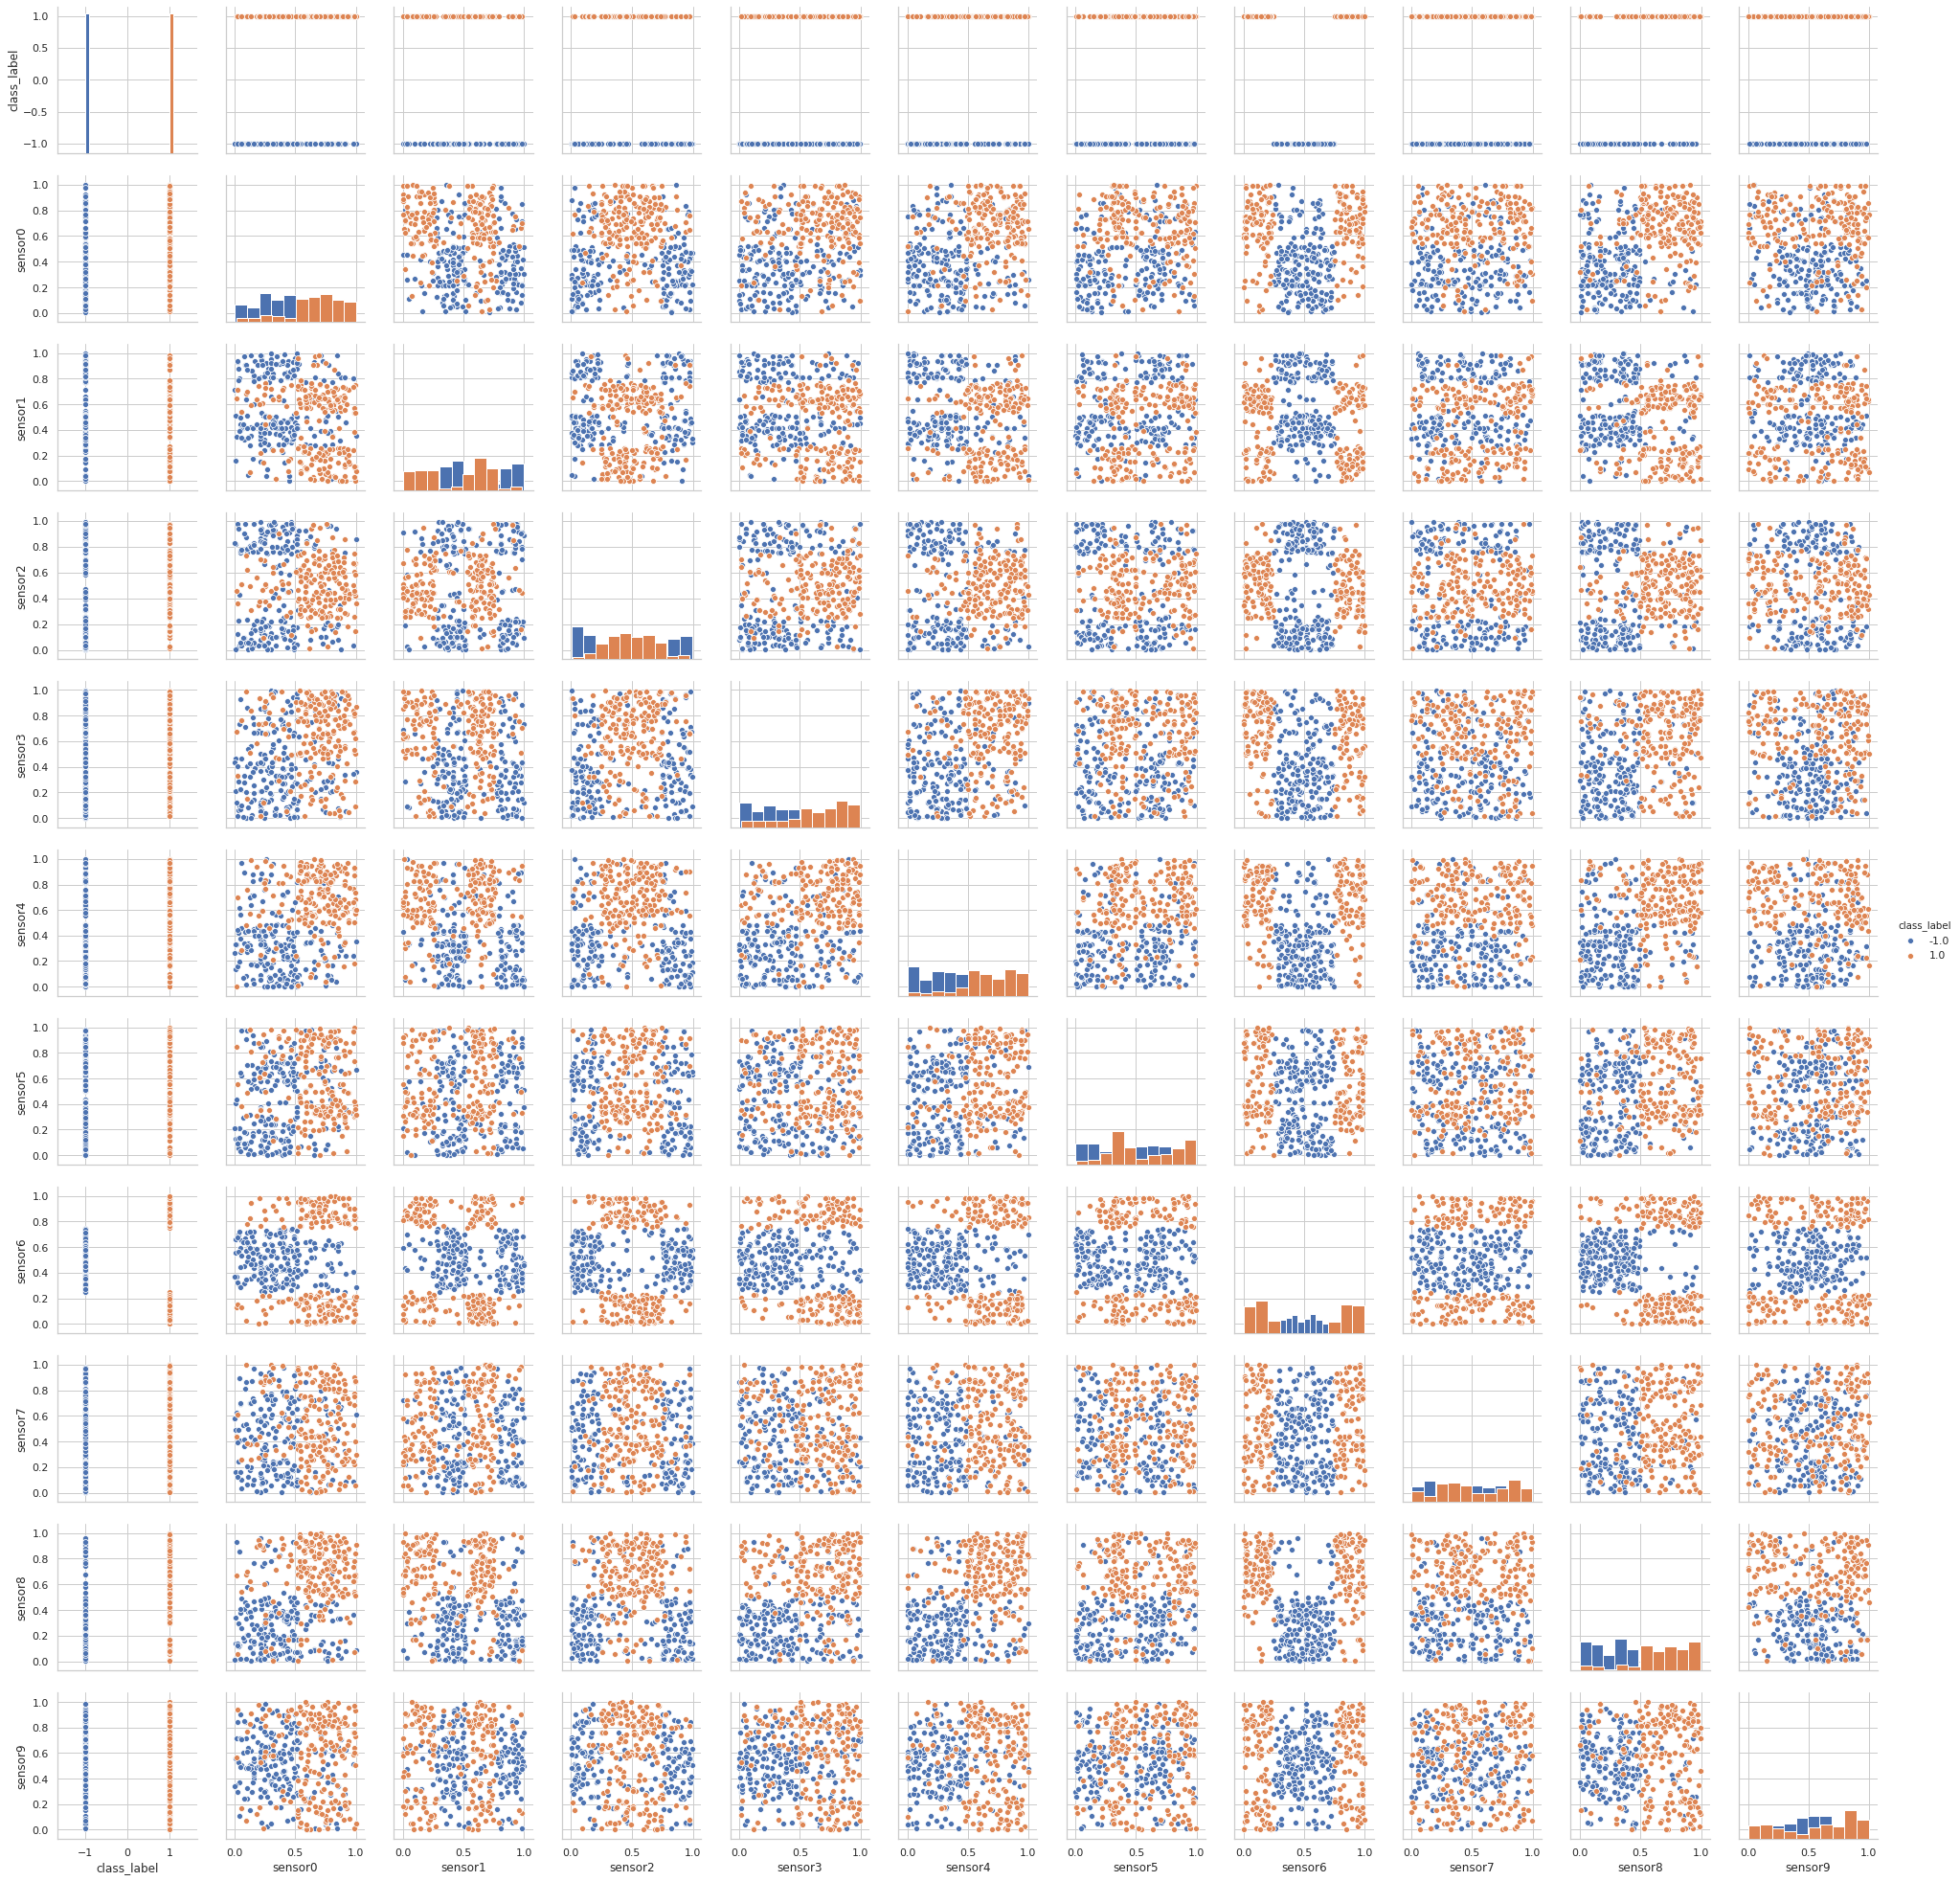

In [ ]:
#Using pairplot to see distribution of single variable and relationship bewteen two variables
g = sns.pairplot(df_all[['class_label','sensor0', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9']], diag_kind='hist',hue='class_label')

In [ ]:
# assigning columns
indep_df = df_all.loc[ : , ['sensor0', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9'] ]
dep_df =  df_all.loc[ : ,[ 'class_label']]     

In [ ]:
from scipy import stats
indep_df[(np.abs(stats.zscore(indep_df)) < 3).all(axis=1)]

,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969
...,...,...,...,...,...,...,...,...,...,...
395,0.433150,0.816109,0.452945,0.065469,0.237093,0.719321,0.577969,0.085598,0.357115,0.070060
396,0.339346,0.914610,0.097827,0.077522,0.484140,0.690568,0.420054,0.482845,0.395148,0.438641
397,0.320118,0.444951,0.401896,0.970993,0.960264,0.138345,0.354927,0.230749,0.204612,0.558889
398,0.059132,0.337426,0.772847,0.099038,0.966042,0.975086,0.532891,0.035839,0.258723,0.709958


In [ ]:
# f_classif: Used only for categorical targets, based on Analysis of Variance (ANOVA) statistical test.
from sklearn.feature_selection import SelectPercentile, f_classif

# Instantiate object
selector_f = SelectPercentile(f_classif, percentile=100)

# Fit and transform
indep_df_best = selector_f.fit_transform(indep_df, dep_df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Top Variables
support = np.asarray(selector_f.get_support())

# Enable scientific notation
pd.set_option('display.float_format', '{:.2e}'.format)

# Column names 
features = np.asarray(indep_df.columns.values)
features_with_support = features[support]

# ANOVA F-value 
fvalue = np.asarray(selector_f.scores_)
fvalue_with_support = fvalue[support]

# p-values 
pvalues = np.asarray(selector_f.pvalues_)
pvalues_with_support = pvalues[support]

# Dataframe 
top = pd.DataFrame({'F-value':fvalue_with_support,
                      'p-value':pvalues_with_support},
                     index = features_with_support)

# top.index.name = 'Feature'
print('Top associated features to Class Label\nNumber of features:',len(features_with_support))
print(top.sort_values(by = 'p-value', ascending = 'False'))
print(top.sort_values(by = 'F-value', ascending = 'False'))

Top associated features to Class Label
Number of features: 10
         F-value  p-value
sensor8 3.08e+02 1.66e-51
sensor4 2.33e+02 9.86e-42
sensor0 1.67e+02 4.30e-32
sensor3 9.22e+01 9.06e-20
sensor1 2.70e+01 3.27e-07
sensor5 2.11e+01 5.99e-06
sensor7 1.27e+01 4.18e-04
sensor9 3.62e+00 5.79e-02
sensor2 5.99e-01 4.39e-01
sensor6 2.19e-02 8.82e-01
         F-value  p-value
sensor6 2.19e-02 8.82e-01
sensor2 5.99e-01 4.39e-01
sensor9 3.62e+00 5.79e-02
sensor7 1.27e+01 4.18e-04
sensor5 2.11e+01 5.99e-06
sensor1 2.70e+01 3.27e-07
sensor3 9.22e+01 9.06e-20
sensor0 1.67e+02 4.30e-32
sensor4 2.33e+02 9.86e-42
sensor8 3.08e+02 1.66e-51


In [ ]:
# Split training data into train and test sets
data_train, data_test, target_train, target_test = train_test_split(indep_df,dep_df,test_size = 0.33,random_state=123)

# Shape of the dataset
[subset.shape for subset in [data_train,data_test,target_train,target_test]]

[(268, 10), (132, 10), (268, 1), (132, 1)]

In [ ]:
# Training Simple Tree
simpleTree = DecisionTreeClassifier(max_depth=5)
simpleTree.fit(data_train,target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
#Training Gradient Boosting
gbmTree = GradientBoostingClassifier(max_depth=5)
gbmTree.fit(data_train,target_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Training Random Forest
rfTree = RandomForestClassifier(max_depth=5)
rfTree.fit(data_train,target_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Print the name and gini importance of each feature
feat_labels = ['sensor0', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9']
for feature in zip(feat_labels, rfTree.feature_importances_):
    print(feature)

('sensor0', 0.13741223444581321)
('sensor1', 0.026584830086053786)
('sensor2', 0.030952736413492297)
('sensor3', 0.12896688164455003)
('sensor4', 0.17846450827398574)
('sensor5', 0.027442417447765564)
('sensor6', 0.1004426664284382)
('sensor7', 0.02210445263713992)
('sensor8', 0.3165194631613102)
('sensor9', 0.03110980946145101)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
# Top variables using RFE
svm = LinearSVC()
# create the RFE model for the svm classifier 
# and select attributes
rfe = RFE(svm, 3)
rfe = rfe.fit(data_train,target_train)
# print summaries for the selection of attributes

for feature in zip(feat_labels, rfe.ranking_):
    print(feature)

('sensor0', 1)
('sensor1', 3)
('sensor2', 6)
('sensor3', 2)
('sensor4', 1)
('sensor5', 8)
('sensor6', 7)
('sensor7', 5)
('sensor8', 1)
('sensor9', 4)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Model performance
print('Simple Tree Performance:')
print('MAE:',metrics.mean_absolute_error(target_test,simpleTree.predict(data_test)))
print('MSE:',metrics.mean_squared_error(target_test,simpleTree.predict(data_test)))

print('Gradient Boosting Tree Performance:')
print('MAE:',metrics.mean_absolute_error(target_test,gbmTree.predict(data_test)))
print('MSE:',metrics.mean_squared_error(target_test,gbmTree.predict(data_test)))

print('Random Forest Tree Performance:')
print('MAE:',metrics.mean_absolute_error(target_test,rfTree.predict(data_test)))
print('MSE:',metrics.mean_squared_error(target_test,rfTree.predict(data_test)))

Simple Tree Performance:
MAE: 0.07575757575757576
MSE: 0.15151515151515152
Gradient Boosting Tree Performance:
MAE: 0.0
MSE: 0.0
Random Forest Tree Performance:
MAE: 0.09090909090909091
MSE: 0.18181818181818182


In [ ]:
# Model Performance
simpleTreePerformance = precision_recall_fscore_support(target_test,simpleTree.predict(data_test))
gbmTreePerformance = precision_recall_fscore_support(target_test,gbmTree.predict(data_test))
rfTreePerformance = precision_recall_fscore_support(target_test,rfTree.predict(data_test))

print('Precision, Recall, Fscore, and Support for each class in Simple, Gradient Boosted, and Random Forest Tree Classifiers:'+'\n')
for treeMethod in [simpleTreePerformance,gbmTreePerformance,rfTreePerformance]:
    print('Precision: ',treeMethod[0])
    print('Recall: ',treeMethod[1])
    print('Fscore: ',treeMethod[2])
    print('Support: ',treeMethod[3],'\n')

Precision, Recall, Fscore, and Support for each class in Simple, Gradient Boosted, and Random Forest Tree Classifiers:

Precision:  [0.94029851 0.98461538]
Recall:  [0.984375   0.94117647]
Fscore:  [0.96183206 0.96240602]
Support:  [64 68] 

Precision:  [1. 1.]
Recall:  [1. 1.]
Fscore:  [1. 1.]
Support:  [64 68] 

Precision:  [0.93939394 0.96969697]
Recall:  [0.96875    0.94117647]
Fscore:  [0.95384615 0.95522388]
Support:  [64 68] 



In [ ]:
# Model Performance
print('Confusion Matrix for Simple, Gradient Boosted, and Random Forest Tree Classifiers:')
print('Simple Tree:\n',confusion_matrix(target_test,simpleTree.predict(data_test)),'\n')
print('Gradient Boosted:\n',confusion_matrix(target_test,gbmTree.predict(data_test)),'\n')
print('Random Forest:\n',confusion_matrix(target_test,rfTree.predict(data_test)))

Confusion Matrix for Simple, Gradient Boosted, and Random Forest Tree Classifiers:
Simple Tree:
 [[63  1]
 [ 4 64]] 

Gradient Boosted:
 [[64  0]
 [ 0 68]] 

Random Forest:
 [[62  2]
 [ 4 64]]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

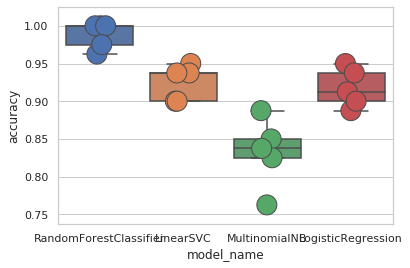

In [ ]:
# different models applied
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, indep_df, dep_df, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=20, jitter=True, edgecolor="gray", linewidth=1)

plt.show()

In [ ]:
# accuracy of different model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                9.25e-01
LogisticRegression       9.18e-01
MultinomialNB            8.33e-01
RandomForestClassifier   9.88e-01
Name: accuracy, dtype: float64